# Causal-Retro-Causal Neural Network

This Notebook presents the Causal-Retro-Causal Neural Network (CRCNN). Because the CRCNN is a further development of Historical Consistant Neural Networks, we assume that you are already familiar with its [tutorial](Hcnn.ipynb). Based on this we will look into the theory and the ideas of the CRCNN architecture. Then the data is prepared for model training. There are some ways presented how to set up a training loop. We start with the simple case without the mirroring trick, which is then introduced in the following section. We will use the mirroring trick and train a model at first only on one batch ans second with multiple batches. At the end of the notebook we will build an ensemble of CRCNNs.

## Theory

As mentioned, the CRCNN is a further development of the HCNN. The HCNN is restricted that only influences of the past can affect the future. In reality, decisions in the present are often made with respect to interests in the future. For instance, you invest into stocks because you believe it has an increasing value in the future. This decision is made in the present with motivation coming from the future. To represent the influence of the future into the past we change the direction of time in a HCNN (retro-causal model). 
We combine both ideas of causal (normal HCNN) and retro-causal (inverted HCNN) in one model. The resulting CRCNNs predictions are a combination of both influences (see figure below). 

<img src=images/crcnn_loop.png width=1000 >

Because of the teacher forcing, we have closed loops (orange) in the architecture. Since the backpropagation algorithm propagates the gradients against the direction of the arrow and therefore in loops, the algorithm does not converge. But losing the teacher forcing in order to get rid of the loops would give us an untrainable model. A suited solution is to approximate the above architecture with a finite unfolding of the loop.

In its simplest version we copy the causal branch of the model and stack it on top of the retro-causal branch (picture below). To get rid of the loop, we delete the teacher forcing in the first causal branch. This is possible because of the shared weights to the top causal branch, where the teacher forcing is applied. This way the first branch is also trainable. 
As a result, both the causal and the retro-causal branch impact the outputs. There are now two versions of outputs. On the one hand, there is the output between the first causal and the retro-causal branch, but there is no teacher forcing in the first branch. On the other hand, we have the top output between the top causal and the retro-causal branch. This output is a combination of two branches with teacher forcing and therefore gives better results.

However, since the possible worse predictions in the first output, the teacher forcing inserts poor information from the causal branch into the retro-causal branch. This continues to the top output. To mitigate this we add alternating copies of causal and retro-causal branches. In each new branch the problem decreases until we have an output in the highest branch that is only slightly affected by the missing teacher forcing in the first branch. The number of branches is under research, but in most cases it is enough to have around 7 branches.

<img src=images/crcnn3.png width=1000 >

In [1]:
import sys, os

sys.path.append(os.path.abspath("../../.."))
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("."))

In [2]:
import torch

from prosper_nn.models.crcnn import CRCNN
from prosper_nn.models.ensemble import Ensemble

import prosper_nn.utils.generate_time_series_data as gtsd
import prosper_nn.utils.create_input_ecnn_hcnn as ci

from prosper_nn.utils import visualize_forecasts

torch.manual_seed(0)

## Data Preparation

The data preparation is similar to that of the HCNN, which you can see in its [tutorial](Hcnn.ipynb#data-preparation).

In [3]:
past_horizon = 30
forecast_horizon = 5
n_features_Y = 2
batchsize = 1
n_batches = 2
n_data = 100

In [4]:
# generate data with "unknown" variables U
Y, U = gtsd.sample_data(n_data, n_features_Y=n_features_Y - 1, n_features_U=1)
Y = torch.cat((Y, U), 1)

# Only use Y as input for the hcnn
Y_batches = ci.create_input(
    Y=Y,
    past_horizon=past_horizon,
    batchsize=batchsize,
    forecast_horizon=forecast_horizon,
)

Similar to the HCNN, the outputs of the model are trained to be zero in the `past_horizon`.

In [5]:
targets_past = torch.zeros((past_horizon, batchsize, n_features_Y))

## Single Causal-Retro-Causal Neural Network (CRCNN)

The chapter gives an overview over the CRCNN model without the mirroring trick. We start with the initialization, continue with the training and finish with forecasting a time series.

### Initialization

The initialization is nearly identical to that of the HCNN because it is implemented with the help of the [HCNNCell](../api/hcnn.rst#prosper_nn.models.hcnn.hcnn_cell.HCNNCell). Therefore, the parameters for initializing the HCNN are also necessary for the CRCNN. But we have an additional `n_branches` parameter. It is the total sum of causal and retro-causal branches in the model. The CRCNN is implemented in such a way that the first branch is always a causal branch. The second will be a retro-causal branch. While increasing the number, copys of the causal and retro-causal branches are added to the model in turns. 
The second additional parameter is the `batchsize` to be able to initialize the `future_bias` that is introduced in the following section.

In [6]:
n_state_neurons = 20
n_branches = 5

In [7]:
crcnn_model = CRCNN(
    n_state_neurons=n_state_neurons,
    n_features_Y=n_features_Y,
    past_horizon=past_horizon,
    forecast_horizon=forecast_horizon,
    n_branches=n_branches,
    batchsize=batchsize,
)

Set the `optimizer` and the `loss_function`.

In [8]:
optimizer = torch.optim.Adam(crcnn_model.parameters())
loss_function = torch.nn.MSELoss()

### Training Loop

The training loop is designed analogous to the HCNN. The only change is that the loss now contains the errors of all outputs in the `past_horizon`. Because there is always an output between a causal and a retro-causal branch, there are `(n_branches - 1) * past_horizon` output layers relevant.

In [9]:
epochs = 10

total_loss = epochs * [0]
for epoch in range(epochs):
    for batch_index in range(0, Y_batches.shape[0]):
        crcnn_model.zero_grad()

        Y_batch = Y_batches[batch_index]
        model_output = crcnn_model(Y_batch)
        past_errors, forecasts = torch.split(model_output, past_horizon, dim=1)

        losses_past = [
            loss_function(past_errors[i][j], targets_past[j])
            for i in range(n_branches - 1)
            for j in range(past_horizon)
        ]
        loss = sum(losses_past) / len(losses_past)
        loss.backward()
        optimizer.step()
        total_loss[epoch] += loss.detach()

### Forecast

Again, forecasts can be calculated similarly as with the HCNN model. Theoretically the best prediction is in the top output. So, we choose the last output in `forecasts` as our final `forecast`.

In [10]:
with torch.no_grad():
    crcnn_model.eval()

    output_forecast = crcnn_model(Y_batches[0, :, 0].unsqueeze(1))
    past_errors, forecast = torch.split(output_forecast[-1], past_horizon)


### Evaluation

We want to visualize the predicted outcome of the model.

#### Postprocessing

Because of the different meaning of the output along the `past_horizon` compared to the output along the `forecast_horizon`, we have to calculate the `expected_timeseries` first before we can visualize the expectation/target comparison.

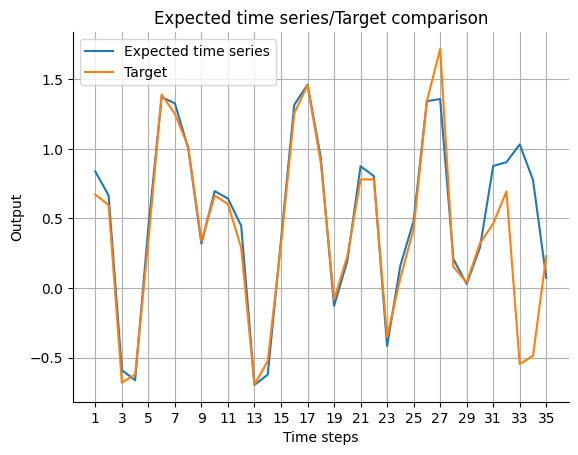

In [11]:
expected_timeseries = torch.cat(
    (torch.add(past_errors.squeeze(), Y[:past_horizon]), forecast.squeeze()), dim=0
).detach()

visualize_forecasts.plot_time_series(
    expected_time_series=expected_timeseries[:, 0],
    target=Y[: (past_horizon + forecast_horizon), 0],
)

## Causal-Retro-Causaul Neural Network with Mirroring

This chapter will proceed as the chapter before, but the mirror trick is used. 
Our goal is to have a symmetric model in the past and future. But when we look into the architecture of the CRCNN, the teacher forcing is only applied during the past. This loop induces equations in the architecture, since after one loop the values have to be the same as before. This can be interpreted as training on a manifold. In the future we don't have the observations to compare the output with the target. Therefore, it is possible for the model to leave the manifold. To stay on it, we use a fake observation in the future. Then we can include teacher forcing in the future, which forces the model on the manifold. 

To get the fake observations we see the forecasts as trainable parameters $\tilde{y}_{t+1}^d, \dots \tilde{y}_{t+n}^d$, like biases, in the output layers. Therefore, $\tilde{y}^d$ will be named `future_bias` in the code. On the one hand, this bias works as an observation in the future and on the other hand, it is the forecast of the model. In this way we get a symmetric model in past and future. 

<img src=images/crcnn_mirror.png width=1000 >

The drawback is that each $\tilde{y}^d$ has to be implemented as a learnable parameter. Therefore, it is not simply possible to use different batches during the training and we have to use all data in one batch. Nevertheless, we will discuss a possible solution later.

### Initialization

Compared to the CRCNN without mirroring, we only set the parameter `mirroring=True` and the mirroring trick is applied.

In [13]:
mirroring = True

In [14]:
crcnn_future_bias_model = CRCNN(
    n_state_neurons=n_state_neurons,
    n_features_Y=n_features_Y,
    past_horizon=past_horizon,
    forecast_horizon=forecast_horizon,
    n_branches=n_branches,
    batchsize=batchsize,
    mirroring=mirroring,
)

Additionally, we need targets for the fake outputs in the future. The objective is to have, like in the past, zero loss since $\tilde{y}^d$ works as observation. So instead of the direct forecast as it was in the previous model we get the `forecast_errors`. This results from the `future_bias` being subtracted from the sum of causal and retro-causal states: $forecast\_errors_t = s_t + s'_t - future\_bias_t$.

In [15]:
targets_future = torch.zeros((forecast_horizon, batchsize, n_features_Y))

Reset the optimizer.

In [16]:
optimizer = torch.optim.Adam(crcnn_future_bias_model.parameters())

### Training Loop

Because the fake observations have to be learned by the model, it is only possible to learn with data in one batch. We will just use the first batch.

For the backpropagation, it is now important to add the `forecast_errors` to the calculation of the loss.

In [17]:
epochs = 10
total_loss = epochs * [0]
Y_batch = Y_batches[0]
for epoch in range(epochs):
    crcnn_future_bias_model.zero_grad()

    model_output = crcnn_future_bias_model(Y_batch)
    past_errors, forecast_errors = torch.split(model_output, past_horizon, dim=1)

    losses_past = [
        loss_function(past_errors[i][j], targets_past[j])
        for i in range(n_branches - 1)
        for j in range(past_horizon)
    ]
    losses_mirror = [
        loss_function(forecast_errors[i][j], targets_future[j])
        for i in range(n_branches - 1)
        for j in range(forecast_horizon)
    ]
    loss = sum(losses_mirror) / len(losses_mirror) + sum(losses_past) / len(losses_past)
    loss.backward()
    optimizer.step()
    total_loss[epoch] += loss.detach()

### Forecasts

In the forecast it is not necessary anymore to use the mirroring, since the model is trained to zero loss. Therefore, the teacher forcing vector is approximately zero and we can leave it out of the model. So, we set `mirroring=False` before calculating the forecast.

Although the teacher forcing is close to zero, the results are a little bit different in each output branch because in the first branch no teacher forcing is applied. We expect the most reliable result between last causal and retro-causal branches.

In [18]:
with torch.no_grad():
    crcnn_future_bias_model.eval()
    crcnn_future_bias_model.mirroring = False

    output_forecast = crcnn_future_bias_model(Y_batches[0, :, 0].unsqueeze(1))
    past_errors, forecast = torch.split(output_forecast[-1], past_horizon)

### Evaluation

We want to compare the predicted output with the real data.

#### Postprocessing

Before we can plot the time series, we have to postprocess the predictions of the model. Like in the HCNN we have to add the true data on the predictions during the `past_horizon`.

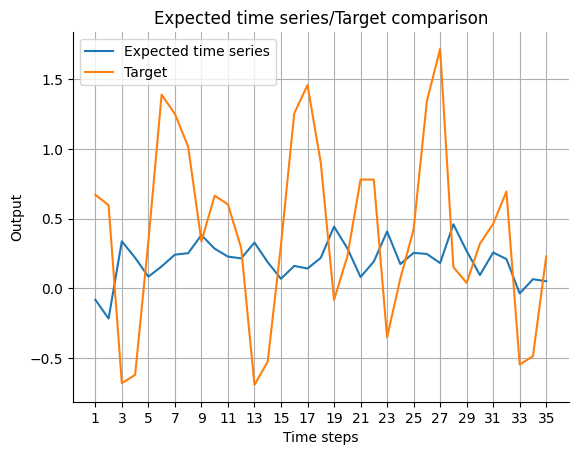

In [19]:
expected_timeseries = torch.cat(
    (torch.add(past_errors.squeeze(), Y[:past_horizon]), forecast.squeeze()), dim=0
).detach()

visualize_forecasts.plot_time_series(
    expected_time_series=expected_timeseries[:, 0],
    target=Y[: (past_horizon + forecast_horizon), 0],
)

## Causal-Retro-Causal Neural Network with Mirroring and Multiple Batches

Because the forecasts of the model with mirroring are learnable parameters, it is not possible to simply change data or batches during training and get reasonable predictions. But if we have too many data for one batch, we can design the training loop a little bit differently to overcome this limitation. 

### Initialization

We want to use the data with different batches again. Therefore we reset the model.

In [20]:
crcnn_future_bias_model = CRCNN(
    n_state_neurons=n_state_neurons,
    n_features_Y=n_features_Y,
    past_horizon=past_horizon,
    forecast_horizon=forecast_horizon,
    n_branches=n_branches,
    batchsize=batchsize,
    mirroring=mirroring,
)

Until now we always used the Adam optimizer. But in this example it is possibly not a good idea to use it. Adam has a momentum term when it applies an optimizer step. When we switch from one batch to another the momentum of the previous batch affects the recent batch. For learning the matrices this is a good idea but for learning the `future_bias` probably not. It is possible that this isn't problematic because the objective to learn the forecast is very easy (linear). Nevertheless, we recommend to use an optimizer without momentum or reset the optimizer between different batches.

In [21]:
optimizer = torch.optim.SGD(crcnn_future_bias_model.parameters(), lr=0.001)

### Training Loop

As already mentioned, the training loop has to be modified to train on multiple batches. The problem is the changing fake observation in the future. With only one batch it is possible to train the `future_bias` during training of the model. With multiple batches this isn't possible because the observations are changing and with them the predictions. To have the right fake observation in the model we save the `future_bias` in a tensor `store_bias` and initialize the data parameter of the `future_bias` in each batch with the according value. Now, we can train the model as in the previous section.

In [22]:
store_bias = torch.empty(
    (Y_batches.shape[0], forecast_horizon, batchsize, n_features_Y)
)

epochs = 10
total_loss = epochs * [0]
for epoch in range(epochs):
    for batch_index in range(0, Y_batches.shape[0]):
        crcnn_future_bias_model.zero_grad()

        Y_batch = Y_batches[batch_index]
        # set the future_bias from store_bias accordingly to the batch
        if epoch == 0:
            crcnn_future_bias_model.future_bias.data = torch.zeros(
                size=(forecast_horizon, batchsize, n_features_Y)
            )
        else:
            crcnn_future_bias_model.future_bias.data = store_bias[batch_index]
        model_output = crcnn_future_bias_model(Y_batch)
        past_error, forecast = torch.split(model_output, past_horizon, dim=1)

        losses_past = [
            loss_function(past_error[i][j], targets_past[j])
            for i in range(n_branches - 1)
            for j in range(past_horizon)
        ]
        losses_mirror = [
            loss_function(forecast[i][j], targets_future[j])
            for i in range(n_branches - 1)
            for j in range(forecast_horizon)
        ]
        loss = sum(losses_mirror) / len(losses_mirror) + sum(losses_past) / len(
            losses_past
        )
        loss.backward()
        optimizer.step()
        total_loss[epoch] += loss.detach()
        # store the new bias in store_bias
        store_bias[batch_index] = crcnn_future_bias_model.future_bias.data.detach()

### Forecast

The forecast is calculated like for one batch. We will make a forecast for the first batch in the data set.

In [23]:
with torch.no_grad():
    crcnn_future_bias_model.eval()
    crcnn_future_bias_model.mirroring = False

    output_forecast = crcnn_future_bias_model(Y_batches[0, :, 0].unsqueeze(1))
    past_errors, forecast = torch.split(output_forecast[-1], past_horizon)


### Evaluation

Also the evaluation is identical to that of the one batch version.

#### Postprocessing

Again the true data is added to the `past_errors` and than concatenated to the forecast. 

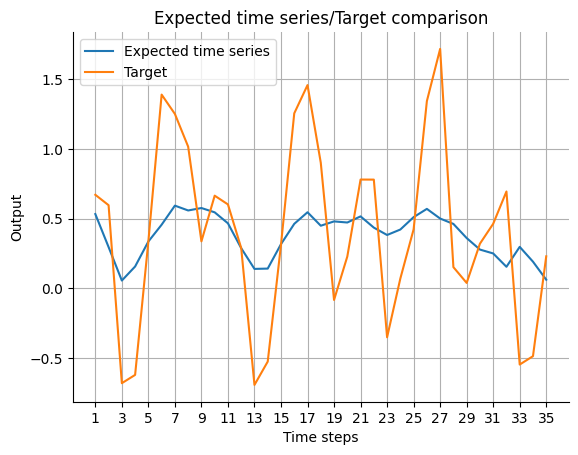

In [24]:
expected_timeseries = torch.cat(
    (torch.add(past_errors.squeeze(), Y[:past_horizon]), forecast.squeeze()), dim=0
).detach()

visualize_forecasts.plot_time_series(
    expected_time_series=expected_timeseries[:, 0],
    target=Y[: (past_horizon + forecast_horizon), 0],
)

## Ensemble of Causal-Retro-Causal Neural Networks

In addition to the CRCNN being a very complex model, the forecasts are still uncertain due to over-parameterization and random initialization. We get rid of this with building an ensemble and using the median forecast. This section builds an ensemble of an CRCNN without mirroring.

### Initialization

The ensemble is built the same way as an ensemble of an HCNN (see [here](Hcnn.ipynb#Ensemble-of-Historical-Consistent-Neural-Networks)). First we have to reset the model itself and then we can use the `Ensemble` class to calculate multiple models at once.

In [25]:
n_models = 3

In [26]:
crcnn_model = CRCNN(
    n_state_neurons=n_state_neurons,
    n_features_Y=n_features_Y,
    past_horizon=past_horizon,
    forecast_horizon=forecast_horizon,
    n_branches=n_branches,
    batchsize=batchsize,
)

In [27]:
crcnn_ensemble = Ensemble(
    model=crcnn_model, n_models=n_models, combination_type="median"
)

Reset the optimizer. Because we don't use mirroring here, we can go back to the Adam optimizer.

In [28]:
optimizer = torch.optim.Adam(crcnn_ensemble.parameters())

### Training Loop
The number of dimensions of the model output increases and we have `ensemble_output.shape() = (n_models + 1, n_branches - 1, past_horizon + forecast_horizon, batchsize, n_features_Y)`. We use the first three dimensions to calculate the loss.

In [29]:
epochs = 10

total_loss = epochs * [0]
for epoch in range(epochs):
    for batch_index in range(0, Y_batches.shape[0]):
        crcnn_ensemble.zero_grad()

        Y_batch = Y_batches[batch_index]
        ensemble_output = crcnn_ensemble(Y_batch)
        outputs, mean = torch.split(ensemble_output, n_models)
        mean = torch.squeeze(mean, 0)
        past_errors, forecasts = torch.split(outputs, past_horizon, dim=2)

        losses_past = [
            loss_function(past_errors[k][i][j], targets_past[j])
            for k in range(n_models)
            for i in range(n_branches - 1)
            for j in range(past_horizon)
        ]
        loss = sum(losses_past) / len(losses_past)
        loss.backward()

        optimizer.step()

        mean_loss = (
            sum(
                [
                    loss_function(mean[-1, i], targets_past[i])
                    for i in range(past_horizon)
                ]
            )
            / past_horizon
        )
        total_loss[epoch] += mean_loss.detach()

### Forecast
The forecast can be done similarly to the CRCNN case without mirroring. We just have to select the last entry of the ensemble dimension additionally.

In [30]:
with torch.no_grad():
    crcnn_ensemble.eval()

    output_forecast = crcnn_ensemble(Y_batches[0, :, 0].unsqueeze(1))
    past_errors, forecast = torch.split(output_forecast[-1, -1], past_horizon)


### Evaluation

To get the real time series we have to do a post-processing step.
Further evaluation can be done like in the [tutorial of the HCNN](Hcnn.ipynb#id3).

#### Postprocessing

Again, during the past the model outputs are added to the observations and the are concatenated to the forecasts.

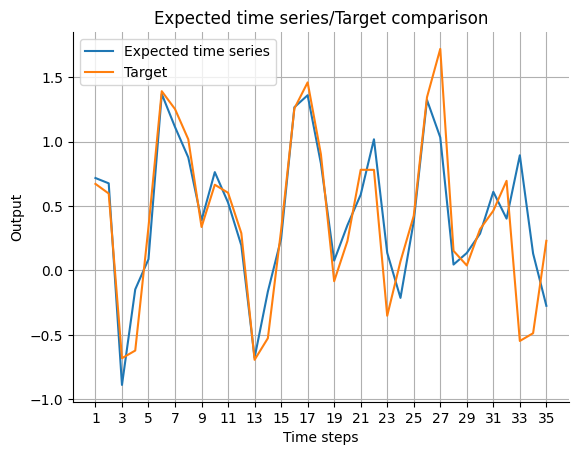

In [31]:
expected_timeseries = torch.cat(
    (torch.add(past_errors.squeeze(), Y[:past_horizon]), forecast.squeeze()), dim=0
).detach()

visualize_forecasts.plot_time_series(
    expected_time_series=expected_timeseries[:, 0],
    target=Y[: (past_horizon + forecast_horizon), 0],
)